# Bonus questions for more in-depth OpenMP 

In this notebook we will explore some of the more advanced OpenMP concepts. Note that not all of these are critical to speed up weather and climate codes so they are structured in this bonus notebook.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "72"
os.environ["OMP_PROC_BIND"] = "close"
os.environ["OMP_PLACES"] = "cores"

## Parallel Execution Time

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B1: Assume you have a program hat is 99% parallelizeable. If we parallelize it but by parallelizing we add parallel overhead to the code (by adding communication). The overhead is at $0.001 \cdot \log(n)$ runtime, where $n$ is the number of cores. Write a simple experiment to see how many nodes are the ideal configuration for this to run as fast as possible?
</div>

In [2]:
import numpy as np
import math

cores = range(1,10000) # TODO
run_time = [(0.01+(0.99/(float)(x))+0.001*math.log(x)) for x in cores] # TODO
index_min = np.argmin(run_time)
print(index_min+1)


990


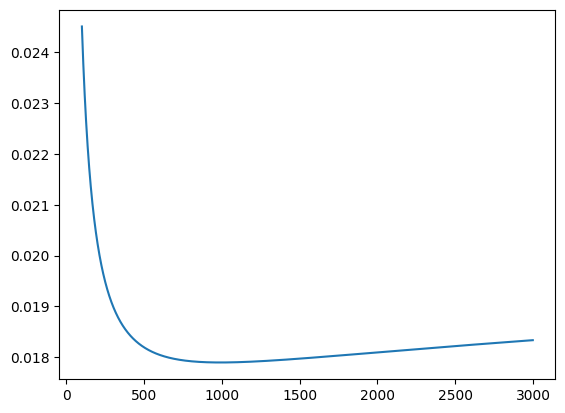

In [3]:
import matplotlib.pyplot as plt

cores = range(100,3000) 
run_time = [(0.01+(0.99/(float)(x))+0.001*math.log(x)) for x in cores]
plt.plot(cores, run_time)

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B2: Can we mathemathically prove that this is actually ideal?
    </div>

$\frac{d}{dn}(0.01+\frac{0.99}{n} + 0.001\log(n)) = 0$

$\frac{0.001n - 0.99}{n^2} = 0$

$n = 990$

## Amdahl's Law

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B3: Assume you have a program that is 99% parallelizeable. If you have three machines available, your laptop with 8 cores, all the fat-nodes of Brutus (3840 cores) and all the Alps CPUs with it's 774'144 cores. How much speedup do these machines offer you?
</div>

In [4]:
cores = [1, 8, 3840, 774144] 
run_time = [0.1 + 0.99/x for x in cores]
speedup = [run_time[0]/x for x in run_time]
print(speedup)

[1.0, 4.871508379888269, 10.871970700537677, 10.899860609111444]


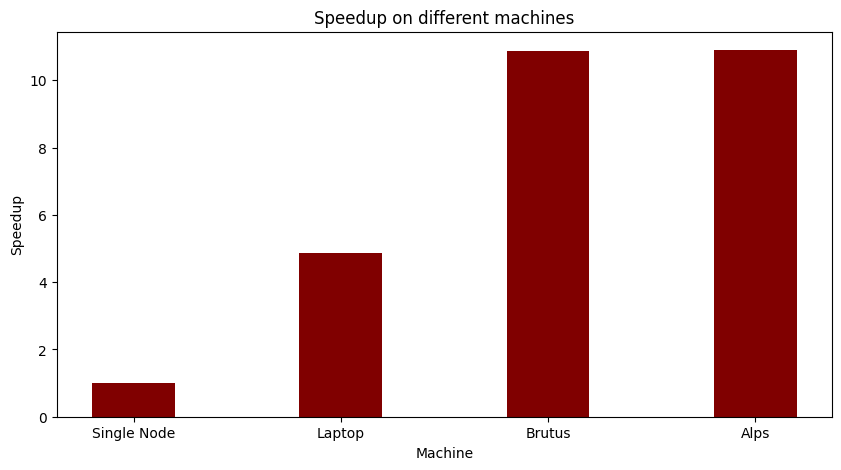

In [5]:
import matplotlib.pyplot as plt

# creating the dataset
courses = ["Single Node", "Laptop", "Brutus", "Alps"]
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, speedup, color ='maroon',
        width = 0.4)
 
plt.xlabel("Machine")
plt.ylabel("Speedup")
plt.title("Speedup on different machines")
plt.show()

# Exploration of intrinsics

In this section we are exploring the difference in speed between various intrinsics

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B4: Write a program <tt>expensive.cpp</tt> where we loop over $n$ iteration and take the $arccos$ of the $cos$ of the $arcsin$ of the $sin$ of the $abs$ value of it's iteration number divided by the total number of iterations.

</div>
We sum all these values up and verify correctness by printing the result.
Ideally the program is parametrized with the number of iterations as well as the number of threads used.


In [6]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt perf/* out*.txt


In [7]:
%%bash
mpic++ expensive.cpp -fopenmp -o expensive.x -O3

In [8]:
%%bash
srun -n 1 ./expensive.x 10000001 2

5e+06
0.37267


The output value should be 5e+06

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B4a: Make sure to add a timer around your code

In [9]:
%%bash
mpic++ expensive.cpp -fopenmp -o expensive.x -O3

In [10]:
%%bash
srun -n 1 ./expensive.x 10000001 12

5e+06
0.372234


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B5: Duplicate the file into a file called <tt>critical.cpp</tt> Parallelize the for loop and make the updates work in critical secions.
How much speedup do we get?
</div>    

In [11]:
%%bash
mpic++ critical.cpp -fopenmp -o critical.x -O3

In [12]:
%%bash
srun -n 1 ./critical.x 10000001 12

5e+06
11.1351


<b>TODO</b><br>
This indicates a slowdown rather than a speedup. The reason for this is that critical sections introduce significant overhead due to the need for synchronization. Each thread must wait to enter the critical section, which serializes the updates to sum and negates the benefits of parallelization.
</div>    

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B6: Duplicate the file into a file called <tt>atomic.cpp</tt> update the critical section to use an atomic instead.
How much speedup do we get?
</div>    

In [13]:
%%bash
mpic++ atomic.cpp -fopenmp -o atomic.x -O3

In [14]:
%%bash
srun -n 1 ./atomic.x 10000001 12

5e+06
0.819451


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B7: Duplicate the file into a file called <tt>reduction.cpp</tt> and change the loop to use the intrinsic reduction. How do times compare between the reduction and the atomic?
</div>

In [15]:
%%bash
mpic++ reduction.cpp -fopenmp -o reduction.x -O3

In [16]:
%%bash
srun -n 1 ./reduction.x  10000001 12

5e+06
0.807904


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B8: Lastly we try to completely parallelize the code and have a single thread sum up the result in <tt>fully_parallel.cpp</tt>. How does that compare to the above times?
</div>

In [17]:
%%bash
mpic++ fully_parallel.cpp -fopenmp -o fully_parallel.x -O3

In [18]:
%%bash
srun -n 1 ./fully_parallel.x 10000001 12

5e+06
0.0385613


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
Now we had a very expensive computation instead of a simple one. We want to copy <tt>fully_parallel.cpp</tt> into <tt>iterations_count_fully_parallel</tt> and <tt>atomic.cpp</tt> into <tt>iterations_count_atomic</tt>.<br>
In the new version we change the computation to just be the iteration index.<br>
    <b>B9:</b> How do the two versions compare to each other? How do they compare to their expensive counterparts?
</div>

In [19]:
%%bash
mpic++ iterations_count_atomic.cpp -fopenmp -o iterations_count_atomic.x -O3
mpic++ iterations_count_fully_parallel.cpp -fopenmp -o iterations_count_fully_parallel.x -O3


In [20]:
%%bash
srun -n 1 ./iterations_count_atomic.x 10000001 12

5e+13
0.359258


In [21]:
%%bash
srun -n 1 ./iterations_count_fully_parallel.x 10000001 12

5e+13
0.00406357


# Exploration of caching
<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B10: Parallelize <tt>fully_parallel.cpp</tt> in a new file <tt>static_small_expensive.cpp</tt> with a static loop schedule of size 1. But we slightly change the output to be 
<br><code>output[i] = acos(cos(asin(sin(abs(input[i]))))) + output[i];</code>
</div>


In [22]:
%%bash
mpic++ static_small_expensive.cpp -fopenmp -o static_small_expensive.x -O3

In [23]:
%%bash
srun -n 1 ./static_small_expensive.x 10000001 12

5e+06
0.0354142


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B11: How does our time change if we move to a static schedule of size 80? Copy <tt>static_small_expensive.cpp</tt> and change it to have a different policy in <tt>static_large_expensive.cpp</tt>
</div>


In [24]:
%%bash
mpic++ static_large_expensive.cpp -fopenmp -o static_large_expensive.x -O3

In [25]:
%%bash
srun -n 1 ./static_large_expensive.x 10000001 12

5e+06
0.0352989


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B12: How do these two results change if we move to a cheap iteration in just adding up the iteration number? <br><code>output[i] = i + output[i];</code> <br>Explore in <tt>static_small_cheap.cpp</tt> and <tt>static_large_cheap.cpp</tt>
</div>



In [26]:
%%bash
mpic++ static_small_cheap.cpp -fopenmp -o static_small_cheap.x -O3
mpic++ static_large_cheap.cpp -fopenmp -o static_large_cheap.x -O3


In [27]:
%%bash
srun -n 1 ./static_small_cheap.x 10000001 12

5e+13
0.00681585


In [28]:
%%bash
srun -n 1 ./static_large_cheap.x 10000001 12

5e+13
0.00424833


In [29]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt perf/* out*.txt
